## Downloading required things

In [12]:
# get dataset from google disk
!conda install -y gdown
!gdown https://drive.google.com/uc?id=1MyLFn80PnqOO53rU1jP9zpdVai_oHMzY

# install skorch wrapper for pytorch
!pip install -U skorch

/bin/bash: conda: command not found
Downloading...
From: https://drive.google.com/uc?id=1MyLFn80PnqOO53rU1jP9zpdVai_oHMzY
To: /content/cv_train.zip
990MB [00:04, 233MB/s]
Requirement already up-to-date: skorch in /usr/local/lib/python3.6/dist-packages (0.9.0)


## Unziping dataset and cleaning

In [13]:
# import libraries for file processing
import os
import zipfile

# unzip file to /kaggle/working folder
with zipfile.ZipFile('./cv_train.zip', 'r') as zip_ref:
    zip_ref.extractall('./cv_train')  

# delete unnecessary file
for dump in os.listdir('./cv_train/cv_train'):
    if dump.split('.')[::-1][0] == 'ini':
        os.remove('./cv_train/cv_train/' + dump)
        print(f'{dump} removed')

desktop.ini removed


## Importing all necessary libraries

In [14]:
# libraries for image processing
import cv2
import numpy as np
import pandas as pd

# pytorch libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

# skorch wrapper classes and functions
from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit
from skorch.callbacks import LRScheduler, Checkpoint 
from skorch.callbacks import Freezer, EarlyStopping

# sklearn models for further stacking
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# albumentations for image augmentation
import albumentations
from albumentations import pytorch

# for multiprocessing
import multiprocessing as mp

# plot graphs for data exploration
import matplotlib.pyplot as plt

## Seed environment

In [15]:
import random


# Here we seed our environmental variables and pytorch variables
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)

## Preparing datasets

In [16]:
# Read train dataset from file
train_dir = './cv_train/cv_train'        
train_files = os.listdir(train_dir)

print(len(train_files))

15875


In [17]:
# class for dataset loading, labeling and augmentation
class PrepareDataset(Dataset):
    def __init__(self, dir_path, file_list, transform=None, mode='train'):
        self.dir_path = dir_path
        self.file_list = file_list
        self.transform = transform
        self.mode = mode
        self.name_to_label = {'bar_chart' : 1, 'diagram' : 2, 'flow_chart' : 3,
                              'graph' : 4, 'growth_chart' : 5, 'pie_chart' : 6,
                              'table' : 7, 'just_image' : 0}
        self.label_to_name = {1 : 'bar_chart', 2 : 'diagram', 3 : 'flow_chart',
                              4 : 'graph', 5 : 'growth_chart', 6 : 'pie_chart',
                              7 : 'table', 0 : 'just_image'}

    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        image_name = os.path.join(self.dir_path, self.file_list[idx])
        
        if image_name.split('.')[::-1][0] == "gif":
            gif = cv2.VideoCapture(image_name)
            _, image = gif.read()
        else:
            image = cv2.imread(image_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        for name, label in self.name_to_label.items():
            if name in image_name:
                self.label = label
                break

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        if self.mode == 'train':
            return image, self.label
        else:
            return image, image_name

In [18]:
# declaration of constant variables
batch_size = 128
num_workers = mp.cpu_count()
img_size = 224
n_classes = 8

In [19]:
# function that prepares dataset for further training
def prepare_datasets(train_dir, train_files):
    # augmentation parameters for train
    data_transforms_train = albumentations.Compose([
        albumentations.Resize(img_size, img_size),
        albumentations.HorizontalFlip(),
        albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.10,
                                        rotate_limit=15),
        albumentations.Normalize(),
        pytorch.ToTensor()
    ]) 

    trainset = PrepareDataset(train_dir, train_files, transform=data_transforms_train)
    
    print(f'Train dataset length: {len(trainset)}')
    
    return trainset

In [20]:
# get prepared datasets from files stored in directory
train_set = prepare_datasets(train_dir, train_files)

# create dataloaders for loading data in batches=128
trainloader = DataLoader(train_set, batch_size=batch_size,
                         pin_memory=True, num_workers=num_workers, shuffle=True)

Train dataset length: 15875


## Exploring the data

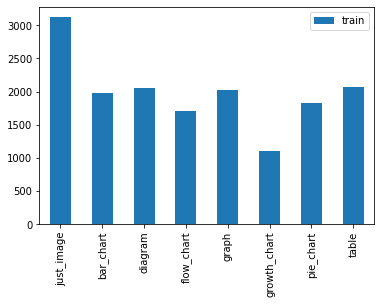

In [21]:
# plot bar chart to observe amount of images by classes in dataset
class_names = ['just_image', 'bar_chart', 'diagram', 'flow_chart', 'graph',
               'growth_chart', 'pie_chart', 'table']

train_images = np.array([X.size() for X, y in iter(train_set)])
train_labels = np.array([y for X, y in iter(train_set)])

_, train_counts = np.unique(train_labels, return_counts=True)
pd.DataFrame({'train': train_counts}, index=class_names).plot.bar()
plt.show()

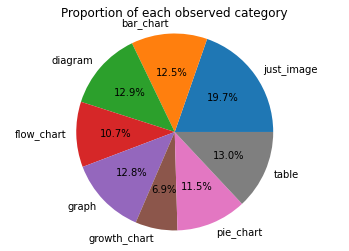

In [22]:
# plot pie chart to observe proportion of classes in dataset
plt.pie(train_counts, explode=(0, 0, 0, 0, 0, 0, 0, 0) , 
        labels=class_names, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

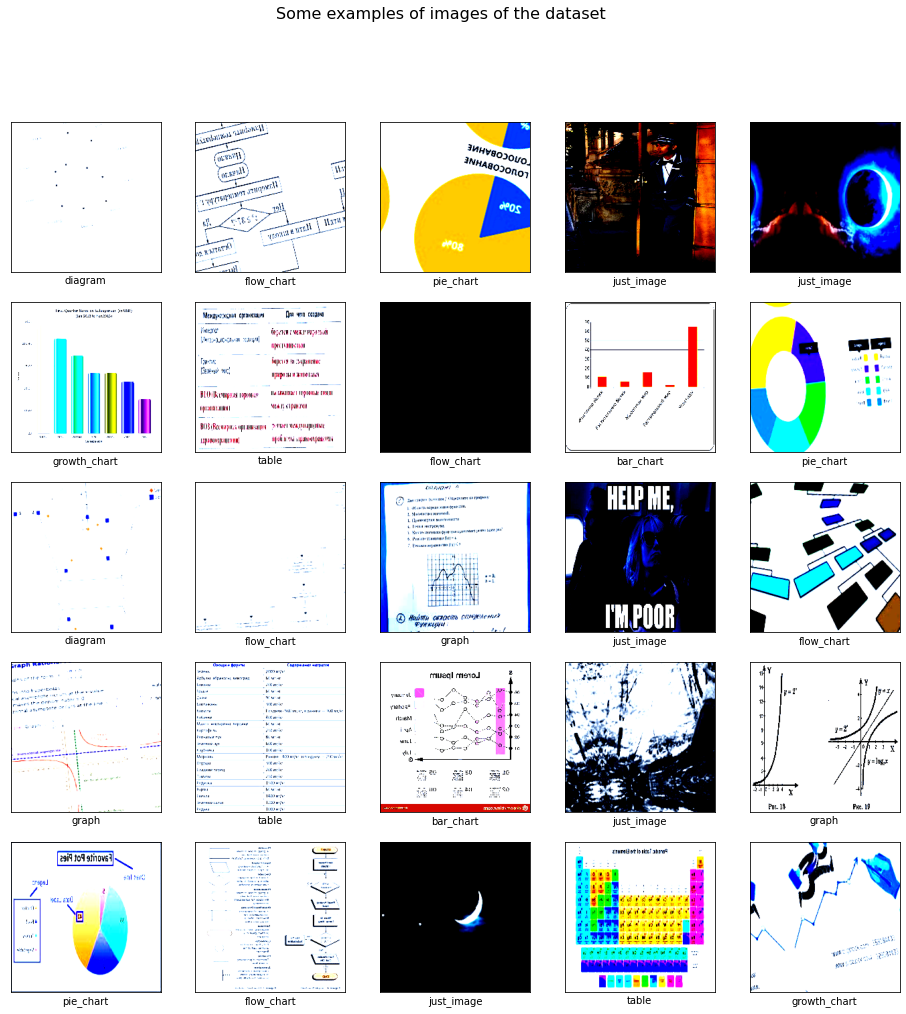

In [23]:
# print images with labels
samples, labels = next(iter(trainloader))

fig = plt.figure(figsize=(16, 16))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(samples[i], (1, 2, 0)), cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[i]])
plt.show()

## Preparing models

In [24]:
# class which uses ResNet50 pretrained model
# + added custom classifier in the last layer
class ResNet50(nn.Module):
    def __init__(self, output_features, num_units=512, drop=0.3337,
                 num_units1=256, drop1=0.1):
        super().__init__()
        model = torchvision.models.resnet50(pretrained=True)
        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
                                nn.Linear(n_inputs, num_units),
                                nn.ReLU(),
                                nn.Dropout(p=drop),
                                nn.Linear(num_units, num_units1),
                                nn.ReLU(),
                                nn.Dropout(p=drop1), 
                                nn.Linear(num_units1, output_features))
        self.model = model
        
    def forward(self, x):
        return self.model(x)

# class which uses DenseNet169 pretrained model
# + added custom classifier in the last layer
class WideResNet50(nn.Module):
    def __init__(self, output_features, num_units=512, drop=0.3337,
                 num_units1=256, drop1=0.1):
        super().__init__()
        model = torchvision.models.wide_resnet50_2(pretrained=True)
        n_inputs = model.classifier.in_features
        model.classifier = nn.Sequential(
                                nn.Linear(n_inputs, num_units),
                                nn.ReLU(),
                                nn.Dropout(p=drop),
                                nn.Linear(num_units, num_units1),
                                nn.ReLU(),
                                nn.Dropout(p=drop1), 
                                nn.Linear(num_units1, output_features))
        self.model = model
        
    def forward(self, x):
        return self.model(x)

# class which uses VGG16 pretrained model
class VGG16_BN(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = torchvision.models.vgg16_bn(pretrained=True)
        n_inputs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(n_inputs, output_features)
        self.model = model
        
    def forward(self, x):
        return self.model(x)
    
class EfficientNet_b3(nn.Module):
    def __init__(self, output_features):
        super().__init__()
        model = EfficientNet.from_pretrained('efficientnet-b3')
        n_inputs = model._fc.in_features
        model._fc = nn.Linear(n_inputs, output_features)
        self.model = model
        
    def forward(self, x):
        return self.model(x)

In [25]:
# callback functions for models

# ResNet50
# callback for Reduce on Plateau scheduler 
lr_scheduler_resnet = LRScheduler(policy='ReduceLROnPlateau',
                                  factor=0.5, patience=1)
# callback for saving the best on validation accuracy model
checkpoint_resnet = Checkpoint(f_params='best_model_resnet50.pkl',
                               monitor='valid_acc_best')
# callback for freezing all layer of the model except the last layer
freezer_resnet = Freezer(lambda x: not x.startswith('model.fc'))
# callback for early stopping
early_stopping_resnet = EarlyStopping(patience=10)

# WideResNet50
# callback for Reduce on Plateau scheduler 
lr_scheduler_wideresnet = LRScheduler(policy='ReduceLROnPlateau',
                                    factor=0.5, patience=1)
# callback for saving the best on validation accuracy model
checkpoint_wideresnet = Checkpoint(f_params='best_model_wideresnet50.pkl',
                                 monitor='valid_acc_best')
# callback for freezing all layer of the model except the last layer
freezer_wideresnet = Freezer(lambda x: not x.startswith('model.classifier'))
# callback for early stopping
early_stopping_wideresnet = EarlyStopping(patience=10)

# VGG16_BN
# callback for Reduce on Plateau scheduler 
lr_scheduler_vgg = LRScheduler(policy='ReduceLROnPlateau',
                               factor=0.5, patience=1)
# callback for saving the best on validation accuracy model
checkpoint_vgg = Checkpoint(f_params='best_model_vgg16_bn.pkl',
                            monitor='valid_acc_best')
# callback for freezing all layer of the model except the last layer
freezer_vgg = Freezer(lambda x: not x.startswith('model.classifier'))
# callback for early stopping
early_stopping_vgg = EarlyStopping(patience=10)

In [26]:
# NeuralNetClassifier for based on ResNet50 with custom parameters
resnet = NeuralNetClassifier(
    # pretrained ResNet50 + custom classifier 
    module=ResNet50,          
    # fine tuning model's inner parameters
    module__output_features=n_classes,
    module__num_units=512,
    module__drop=0.5,
    module__num_units1=512,
    module__drop1=0.5,
    # criterion
    criterion=nn.CrossEntropyLoss,
    # batch_size = 128
    batch_size=batch_size,
    # number of epochs to train
    max_epochs=100,
    # optimizer Adam used
    optimizer=torch.optim.Adam,
    optimizer__lr = 0.001,
    optimizer__weight_decay=1e-6,
    # shuffle dataset while loading
    iterator_train__shuffle=True,
    # load in parallel
    iterator_train__num_workers=num_workers,
    # stratified kfold split of loaded dataset
    train_split=CVSplit(cv=5, stratified=True, random_state=42),
    # callbacks declared earlier
    callbacks=[lr_scheduler_resnet, checkpoint_resnet, 
               freezer_resnet, early_stopping_resnet],
    # use GPU or CPU
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)

/usr/local/lib/python3.6/dist-packages/skorch/dataset.py:271: FutureWarning: Setting a random_state has no effect since cv is not a float. This will raise an error in a future. You should leave random_state to its default (None), or set cv to a float value.
  FutureWarning


In [27]:
# NeuralNetClassifier for based on DenseNet169 with custom parameters
wideresnet = NeuralNetClassifier(
    # pretrained WideResNet50 + custom classifier 
    module=WideResNet50, 
    # fine tuning model's inner parameters
    module__output_features=n_classes,
    module__num_units=512,
    module__drop=0.5,
    module__num_units1=512,
    module__drop1=0.5,
    # criterion
    criterion=nn.CrossEntropyLoss,
    # batch_size = 128
    batch_size=batch_size,
    # number of epochs to train
    max_epochs=100,
    # optimizer Adam used
    optimizer=torch.optim.Adam,
    optimizer__lr = 0.001,
    optimizer__weight_decay=1e-6,
    # shuffle dataset while loading
    iterator_train__shuffle=True,
    # load in parallel
    iterator_train__num_workers=num_workers,
    # stratified kfold split of loaded dataset
    train_split=CVSplit(cv=5, stratified=True, random_state=42),
    # callbacks declared earlier
    callbacks=[lr_scheduler_wideresnet, checkpoint_wideresnet, 
               freezer_wideresnet, early_stopping_wideresnet],
    # use GPU or CPU
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)

/usr/local/lib/python3.6/dist-packages/skorch/dataset.py:271: FutureWarning: Setting a random_state has no effect since cv is not a float. This will raise an error in a future. You should leave random_state to its default (None), or set cv to a float value.
  FutureWarning


In [28]:
# NeuralNetClassifier for based on VGG16 with custom parameters
vgg = NeuralNetClassifier(
    # pretrained VGG16
    module=VGG16_BN,
    # fine tuning model's inner parameters
    module__output_features=n_classes, 
    # criterion
    criterion=nn.CrossEntropyLoss,
    # batch_size = 128
    batch_size=batch_size,
    # number of epochs to train
    max_epochs=100,
    # optimizer Adam used
    optimizer=torch.optim.Adam,
    optimizer__lr = 0.001,
    optimizer__weight_decay=1e-6,
    # shuffle dataset while loading
    iterator_train__shuffle=True,
    # load in parallel
    iterator_train__num_workers=num_workers, 
    # stratified kfold split of loaded dataset
    train_split=CVSplit(cv=5, stratified=True, random_state=42),
    # callbacks declared earlier
    callbacks=[lr_scheduler_vgg, checkpoint_vgg,
               freezer_vgg, early_stopping_vgg],
    # use GPU or CPU
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)

/usr/local/lib/python3.6/dist-packages/skorch/dataset.py:271: FutureWarning: Setting a random_state has no effect since cv is not a float. This will raise an error in a future. You should leave random_state to its default (None), or set cv to a float value.
  FutureWarning


## Training the models

In [29]:
!nvidia-smi

Wed Sep 30 12:47:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    31W / 250W |    791MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [30]:
# Load y_train labels for training in Skorch 
# (labels in trainset are ignored while training)
y_train = np.array([y for X, y in iter(train_set)])

fit prepared model with custom parameters

In [ ]:
resnet.fit(train_set, y=y_train)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:603: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  epoch    train_loss    valid_acc    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        0.8262       0.8476        0.4837     +  95.4580
      2        0.5109       0.8765        0.4020     +  94.6929
      3        0.4189       0.8872        0.3727     +  94.8357
      4        0.4069       0.8954        0.3544     +  95.3397
      5        0.3629       0.8932        0.3502        95.5045
      6        0.3552       0.8957        0.3554     +  94.8122
      7        0.3421       0.9002        0.3389     +  95.6541
      8        0.3330       0.9014        0.3224     +  94.8641


In [ ]:
wideresnet.fit(train_set, y=y_train)

In [ ]:
vgg16.fit(train_set, y=y_train)

## Stacking the models

In [ ]:
# ResNet50
resnet.initialize()
resnet.load_params(f_params='/kaggle/input/best-models/best_model_resnet50.pkl')

# DenseNet169
densenet.initialize()
densenet.load_params(f_params='/kaggle/input/best-models/best_model_densenet169.pkl')

# VGG16
vgg.initialize()
vgg.load_params(f_params='/kaggle/input/best-models/best_model_vgg16.pkl')

# ensemble
models = [resnet, densenet, vgg]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [ ]:
# create validation dataset (30%) by splitting train dataset (70%)
valid_size = int(len(train_files) * 0.3)
trainset, validset = random_split(train_set, 
                                  (len(train_files)-valid_size, valid_size))

# create dataloader for loading data in batches=128
validloader = DataLoader(validset, batch_size=batch_size, pin_memory=True)

In [ ]:
# predict on validation set ResNet50
pred_resnet = np.array([])
for batch_idx, (X_test, labels) in enumerate(validloader):
    pred_resnet = np.append(pred_resnet, resnet.predict(X_test).tolist())
print('ResNet50 prediction done!')
    
# predict on validation set DenseNet169
pred_densenet = np.array([])
for batch_idx, (X_test, labels) in enumerate(validloader):
    pred_densenet = np.append(pred_densenet, densenet.predict(X_test).tolist())
print('DenseNet169 prediction done!')

# predict on validation set VGG16
pred_vgg = np.array([])
for batch_idx, (X_test, labels) in enumerate(validloader):
    pred_vgg = np.append(pred_vgg, vgg.predict(X_test).tolist())
print('VGG16 prediction done!')

ResNet50 prediction done!
DenseNet169 prediction done!
VGG16 prediction done!


In [ ]:
# extract labels from validation set
y_valid = np.array([y for X, y in iter(validset)])

In [ ]:
pd.DataFrame(np.column_stack((pred_resnet, pred_densenet, pred_vgg, y_valid))[25:50],
            columns=['ResNet50', 'DenseNet169', 'VGG16', 'True Label'])

,ResNet50,DenseNet169,VGG16,True Label
0,6.0,6.0,6.0,6.0
1,0.0,0.0,0.0,0.0
2,4.0,4.0,4.0,4.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,7.0,7.0,7.0,7.0
6,7.0,7.0,7.0,7.0
7,7.0,7.0,7.0,7.0
8,1.0,1.0,1.0,1.0
9,5.0,4.0,0.0,0.0


In [ ]:
# Decision Tree Classifier
clf1 = DecisionTreeClassifier(random_state=4)
clf1.fit(np.column_stack((pred_resnet, pred_densenet, pred_vgg)), y_valid)

# Support Vector Machine Classifier
clf2 = SVC(random_state=4)
clf2.fit(np.column_stack((pred_resnet, pred_densenet, pred_vgg)), y_valid)

# Random Forest Classifier
clf3 = RandomForestClassifier(random_state=4)
clf3.fit(np.column_stack((pred_resnet, pred_densenet, pred_vgg)), y_valid)

# Gradient Boosting Classifier
clf4 = GradientBoostingClassifier(learning_rate=0.05, max_depth=1, random_state=4)
clf4.fit(np.column_stack((pred_resnet, pred_densenet, pred_vgg)), y_valid)

GradientBoostingClassifier(learning_rate=0.05, max_depth=1, random_state=4)

In [ ]:
clfs = ['Decision Tree', 'SVC', 'Random Forest', 'Gradient Boosting']
scores = []
for clf in [clf1, clf2, clf3, clf4]:
    scores.append(
        cross_val_score(clf, np.column_stack((pred_resnet, pred_densenet, pred_vgg)),
                        y_valid, scoring='accuracy', cv=5))

pd.DataFrame(scores, index=clfs, columns=[i for i in range(1, 6)])

,1,2,3,4,5
Decision Tree,0.946485,0.951731,0.952731,0.950630,0.953782
SVC,0.933893,0.942288,0.949580,0.942227,0.944328
Random Forest,0.947534,0.951731,0.952731,0.952731,0.952731
Gradient Boosting,0.953830,0.952781,0.959034,0.960084,0.952731


In [ ]:
# Voting Classifier
eclf = VotingClassifier(estimators=[('dt', clf1), ('svc', clf2),
                                    ('rf', clf3), ('gbc', clf4)], voting='hard')
# output results of cross validation score
for clf, label in zip([clf1, clf2, clf3, clf4, eclf], 
                      ['Desicion Trees', 'SVC', 'Random Forest',
                       'Gradient Boosting', 'Ensemble']):
    scores = cross_val_score(clf, np.column_stack((pred_resnet, pred_densenet, pred_vgg)),
                             y_valid, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.00) [Desicion Trees]
Accuracy: 0.94 (+/- 0.01) [SVC]
Accuracy: 0.95 (+/- 0.00) [Random Forest]
Accuracy: 0.96 (+/- 0.00) [Gradient Boosting]
Accuracy: 0.95 (+/- 0.00) [Ensemble]


In [ ]:
# fit Voting Classifier
eclf.fit(np.column_stack((pred_resnet, pred_densenet, pred_vgg)), y_valid)

VotingClassifier(estimators=[('dt', DecisionTreeClassifier(random_state=4)),
                             ('svc', SVC(random_state=4)),
                             ('rf', RandomForestClassifier(random_state=4)),
                             ('gbc',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=1,
                                                         random_state=4))])

In [ ]:
# list to store names of images
test_names_list = []

# predict on test set ResNet50
test_pred_resnet = np.array([])
for batch_idx, (X_test, names) in enumerate(testloader):
    test_pred_resnet = np.append(test_pred_resnet, resnet.predict(X_test).tolist())
    test_names_list += [name.split('/')[::-1][0] for name in names]

# predict on test set DenseNet169
test_pred_densenet = np.array([])
for batch_idx, (X_test, names) in enumerate(testloader):
    test_pred_densenet = np.append(test_pred_densenet, densenet.predict(X_test).tolist())

# predict on test set VGG16
test_pred_vgg = np.array([])
for batch_idx, (X_test, names) in enumerate(testloader):
    test_pred_vgg = np.append(test_pred_vgg, vgg.predict(X_test).tolist())

In [ ]:
# predict Voting Classifier with 4 estimators
final = eclf.predict(np.column_stack((test_pred_resnet, test_pred_densenet, test_pred_vgg)))

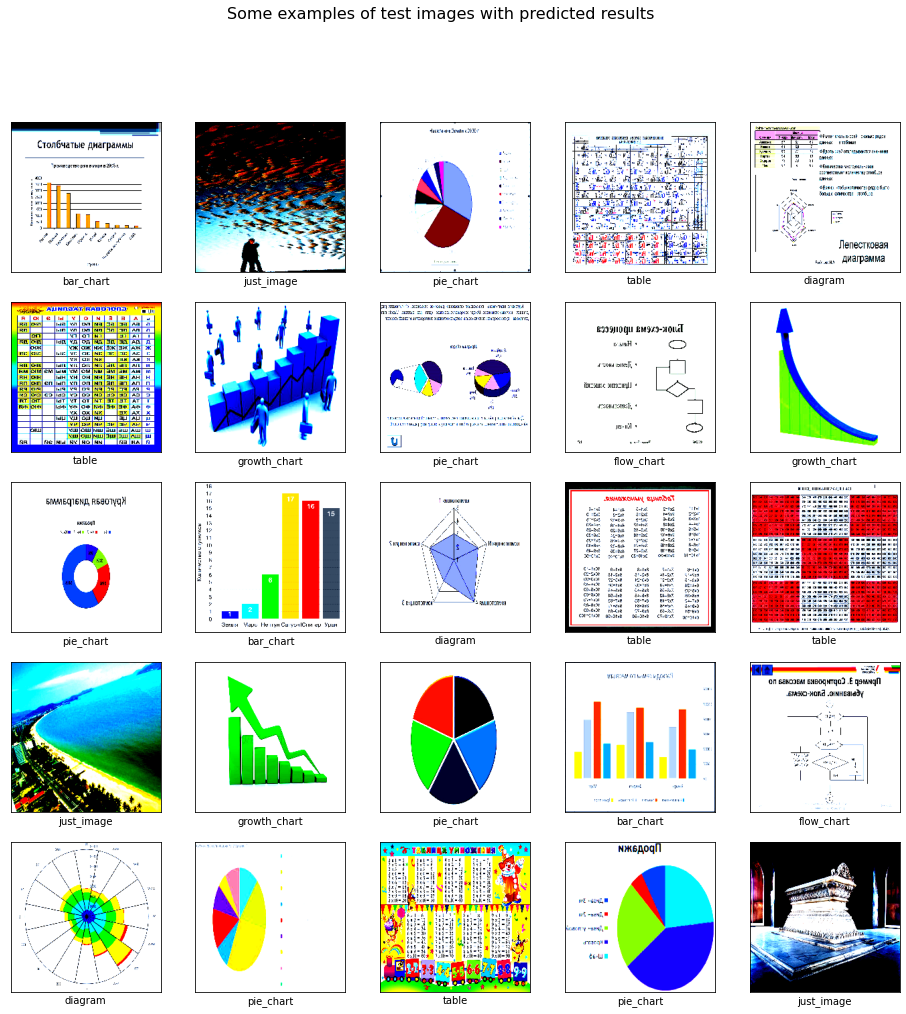

In [ ]:
# print images with labels
samples, names = next(iter(testloader))

fig = plt.figure(figsize=(16, 16))
fig.suptitle("Some examples of test images with predicted results", fontsize=16)
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.transpose(samples[i], (1, 2, 0)), cmap=plt.cm.binary)
    plt.xlabel(class_names[final[i]])
plt.show()